In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

### Data

In [2]:
features, labels = make_moons(n_samples=5000, random_state=42, noise=0.1)

In [3]:
features.shape, labels.shape

((5000, 2), (5000,))

In [4]:
features[:5]

array([[-0.1196884 ,  1.03684845],
       [ 0.03370055,  0.2493631 ],
       [ 0.03864294,  0.33033539],
       [ 0.22222051,  1.03355193],
       [ 0.74448612,  0.69288687]])

In [5]:
labels[:5]

array([0, 1, 1, 0, 0])

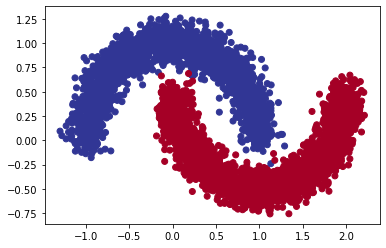

In [6]:
plt.scatter(features[:,0], features[:,1], c = labels, cmap = plt.cm.RdYlBu_r)

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.85666943 -0.22529853]
 [-0.95876904  0.19594093]
 [ 0.54424186  0.97188029]
 [ 0.05268893  1.1756221 ]
 [ 0.90144916  0.11526693]
 [-0.43276658  1.03145289]
 [ 0.04397173  0.21557212]
 [ 0.38340447 -0.24434827]
 [-0.85561427  0.37397076]
 [ 1.99650136  0.11446811]], shape=(10, 2), dtype=float64) 
 tf.Tensor([1 0 0 0 0 0 1 1 0 1], shape=(10,), dtype=int64)


### Initializing Model Parameters

In [9]:
num_inputs = 2
num_outputs = 2
num_hiddens = 200

W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2]

### Softmax Activation

In [10]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

### ReLU Activation

In [11]:
def relu(X):
    return tf.math.maximum(X, 0)

### Defining the Model

In [12]:
def net(X):
    X = tf.reshape(tf.cast(X, dtype=tf.float32), (-1, num_inputs))
    H1 = relu(tf.matmul(X, W1) + b1)
    return softmax(tf.matmul(H1, W2) + b2)

### Loss Function

In [13]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### Optimization

#### Combines all these techniques

#### The Algorithm

##### Calculate momentum and also the second moment of the gradient as state variables

$\begin{split}\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2
\end{aligned}\end{split}$

#### Normalization

$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}$

#### Update equation

$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$

#### Compute updates

$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'$

In [14]:
def init_adam_states():
    v_W1 = tf.Variable(tf.zeros((num_inputs, num_hiddens)))
    v_b1 = tf.Variable(tf.zeros(num_hiddens))
    v_W2 = tf.Variable(tf.zeros((num_hiddens, num_outputs)))
    v_b2 = tf.Variable(tf.zeros(num_outputs))

    s_W1 = tf.Variable(tf.zeros((num_inputs, num_hiddens)))
    s_b1 = tf.Variable(tf.zeros(num_hiddens))
    s_W2 = tf.Variable(tf.zeros((num_hiddens, num_outputs)))
    s_b2 = tf.Variable(tf.zeros(num_outputs))
    
    return ((v_W1, s_W1), (v_b1, s_b1), (v_W2, s_W2), (v_b2, s_b2))

In [15]:
def minibatch_sgd_adam(params, grads, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s), grad in zip(params, states, grads):
        v[:].assign(beta1 * v  + (1 - beta1) * grad)
        s[:].assign(beta2 * s + (1 - beta2) * tf.math.square(grad))
        
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        
        p[:].assign(p - hyperparams['lr'] * v_bias_corr
                    / tf.math.sqrt(s_bias_corr) + eps)

### Training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [17]:
X_train.shape, X_test.shape

((3750, 2), (1250, 2))

In [18]:
num_epochs = 10
states = init_adam_states()
loss = cross_entropy

### Scheduler

- update rate at which the parameters are being updated

Warmup - warmup period during which the learning rate increases to its initial maximum and to cool down the rate until the end of the optimization process.

In [19]:
import math

class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

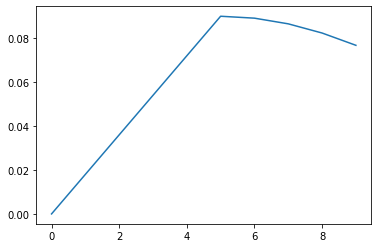

In [20]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.09, final_lr=0.01)
plt.plot(tf.range(num_epochs), [scheduler(t) for t in range(num_epochs)])

In [21]:
scheduler(num_epochs)

0.06999999999999999

In [22]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, X_train, y_train):
      with tf.GradientTape() as g:
        l = tf.math.reduce_mean(loss(net(X), y))

      grads = g.gradient(l, params)
      minibatch_sgd_adam(params, grads, states, {'lr': scheduler(epoch), 't': 1})

### Decision Boundary

In [23]:
def plot_decision_boundary(net, X, y):
    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] 
    # Make predictions using the trained model
    y_pred = np.array(net(x_in)).argmax(axis=1)
    # Check for multi-class
    if y_pred[0].size > 1:
        print("doing multiclass classification...")
        # We have to reshape our predictions to get them ready for plotting
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        print("doing binary classifcation...")
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

doing binary classifcation...


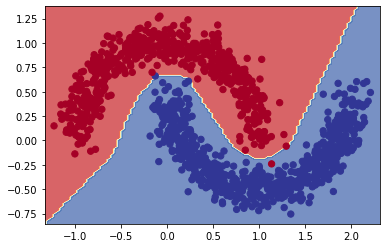

In [24]:
plot_decision_boundary(net, X_test, y_test)